In [2]:
import os
import json
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from safetensors.torch import load_file
from tqdm.auto import tqdm

import wandb
api = wandb.Api()

/n/home04/ericjm/.conda/envs/narrow/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
username = "ericjmichaud_"
project_name = "huggingface"
run_dir = "/n/netscratch/iaifi_lab/Lab/ericjm/narrow/pruneandtrain01"

runs = api.runs(f"{username}/{project_name}")
run_ids_prune = {}
for run in runs:
    if run_dir in run.name:
        run_ids_prune[run.name] = run.id

data_prune = {}
for i, (run_name, run_id) in tqdm(enumerate(run_ids_prune.items())):
    try:
        run = api.run(f"{username}/{project_name}/{run_id}")
        config = run.config
        summary = run.summary
        history = pd.DataFrame(list(run.scan_history()))
        mask = torch.load(os.path.join(run_name, "pruning_mask.pt"), map_location=torch.device("cpu"))
        n_params = sum(m.sum().item() for m in mask.values())
        data_prune[run_name] = {
            "config": config,
            "summary": summary,
            "history": history,
            "n_params": n_params
        }
    except Exception as e:
        print(f"Error loading run {run_name}: {e}")

7it [00:43,  6.22s/it]


In [4]:
run_ids_prune

{'/n/netscratch/iaifi_lab/Lab/ericjm/narrow/pruneandtrain01/n0.50_r0.20': 'n8w1edid',
 '/n/netscratch/iaifi_lab/Lab/ericjm/narrow/pruneandtrain01/n0.50_r0.50': 'aro27qes',
 '/n/netscratch/iaifi_lab/Lab/ericjm/narrow/pruneandtrain01/n0.80_r0.50': 'yzfpgpqj',
 '/n/netscratch/iaifi_lab/Lab/ericjm/narrow/pruneandtrain01/n0.90_r0.50': 'd7b6micb',
 '/n/netscratch/iaifi_lab/Lab/ericjm/narrow/pruneandtrain01/n0.90_r0.90': '1q2y2fo7',
 '/n/netscratch/iaifi_lab/Lab/ericjm/narrow/pruneandtrain01/n0.80_r0.80': 'kg4axgzq',
 '/n/netscratch/iaifi_lab/Lab/ericjm/narrow/pruneandtrain01/n0.95_r0.50': 'v3hh8bd6'}

In [5]:
username = "ericjmichaud_"
project_name = "huggingface"
run_dir_random = "/n/netscratch/iaifi_lab/Lab/ericjm/narrow/pruneandtrainrandom00"

runs_random = api.runs(f"{username}/{project_name}")
run_ids_random = {}
for run in runs_random:
    if run_dir_random in run.name:
        run_ids_random[run.name] = run.id

data_random = {}
for i, (run_name, run_id) in tqdm(enumerate(run_ids_random.items())):
    try:
        run = api.run(f"{username}/{project_name}/{run_id}")
        config = run.config
        summary = run.summary
        history = pd.DataFrame(list(run.scan_history()))
        mask = torch.load(os.path.join(run_name, "pruning_mask.pt"), map_location=torch.device("cpu"))
        n_params = sum(m.sum().item() for m in mask.values())
        data_random[run_name] = {
            "config": config,
            "summary": summary,
            "history": history,
            "n_params": n_params
        }
    except Exception as e:
        print(f"Error loading run {run_name}: {e}")

3it [00:18,  6.09s/it]


In [6]:
run_ids_random

{'/n/netscratch/iaifi_lab/Lab/ericjm/narrow/pruneandtrainrandom00/n0.80_r0.50': 'kssphsng',
 '/n/netscratch/iaifi_lab/Lab/ericjm/narrow/pruneandtrainrandom00/n0.50_r0.20': 'oonutas9',
 '/n/netscratch/iaifi_lab/Lab/ericjm/narrow/pruneandtrainrandom00/n0.90_r0.90': 'o3k6sn9h'}

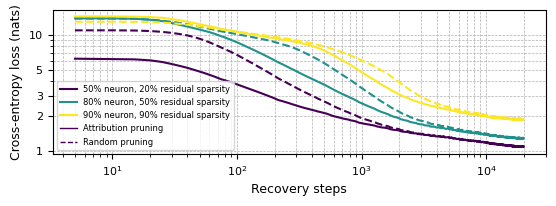

In [ ]:
sparsities = ["n0.50_r0.20", "n0.80_r0.50", "n0.90_r0.90"]
names = [r"50% neuron, 20% residual sparsity", r"80% neuron, 50% residual sparsity", r"90% neuron, 90% residual sparsity"]

plt.figure(figsize=(5.5, 2))

colors = plt.cm.viridis(np.linspace(0, 1, len(sparsities)))
for i, sparsity in enumerate(sparsities):
    run_name_prune = f"/n/netscratch/iaifi_lab/Lab/ericjm/narrow/pruneandtrain01/{sparsity}"
    run_name_random = f"/n/netscratch/iaifi_lab/Lab/ericjm/narrow/pruneandtrainrandom00/{sparsity}"
    history_prune = data_prune[run_name_prune]["history"]
    ema_loss_prune = history_prune['train/loss'].ewm(alpha=0.01).mean().to_numpy()
    plt.plot(history_prune['train/global_step'], ema_loss_prune, color=colors[i], label=f"{names[i]}")
    history_random = data_random[run_name_random]["history"]
    ema_loss_random = history_random['train/loss'].ewm(alpha=0.01).mean().to_numpy()
    plt.plot(history_random['train/global_step'], ema_loss_random, color=colors[i], linestyle='--')

plt.xscale('log')
plt.yscale('log')

from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color=colors[0], lw=1),
                Line2D([0], [0], color=colors[0], linestyle='--', lw=1)]
                
# Add the sparsity legend entries plus the line style indicators
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles + custom_lines, 
           labels + ['Attribution pruning', 'Random pruning'],
           loc='lower left', prop={'size': 6})

# add grid
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.xlabel("Recovery steps", fontsize=9)
plt.ylabel("Cross-entropy loss (nats)", fontsize=9)

plt.xticks(fontsize=8)
plt.yticks([1, 2, 3, 5, 10], ['1', '2', '3', '5', '10'], fontsize=8)

plt.tight_layout(pad=0.5)
plt.savefig("figures/random_vs_attribution_recovery_curves.pdf")

In [32]:
sparsity = "n0.50_r0.20"
run_name_prune = f"/n/netscratch/iaifi_lab/Lab/ericjm/narrow/pruneandtrain01/{sparsity}"
run_name_random = f"/n/netscratch/iaifi_lab/Lab/ericjm/narrow/pruneandtrainrandom00/{sparsity}"
history_prune = data_prune[run_name_prune]["history"]
ema_loss_prune = history_prune['train/loss'].ewm(alpha=0.01).mean().to_numpy()
history_random = data_random[run_name_random]["history"]
ema_loss_random = history_random['train/loss'].ewm(alpha=0.01).mean().to_numpy()

In [43]:
# get the first index where the ema_loss drops below 1.3
parity_index = np.where(ema_loss_prune < 1.3)[0][0]
parity_index

np.int64(1072)

In [44]:
ema_loss_prune[parity_index], ema_loss_random[parity_index]

(np.float64(1.2994619871124964), np.float64(1.3013268340469784))

In [46]:
history_prune['train/global_step'][parity_index], history_random['train/global_step'][parity_index]

(np.int64(5365), np.int64(5365))

Text(0, 0.5, 'Cross-entropy loss (nats)')

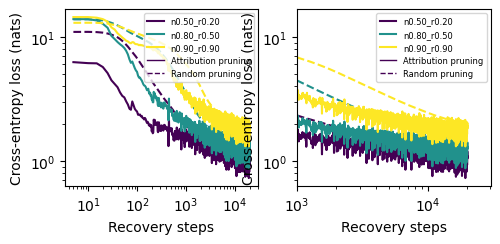

In [ ]:
# compare recovery runs after random vs. attribution pruning

sparsities = ["n0.50_r0.20", "n0.80_r0.50", "n0.90_r0.90"]


plt.figure(figsize=(5.5, 2.3))

plt.subplot(1, 2, 1)
colors = plt.cm.viridis(np.linspace(0, 1, len(sparsities)))
for i, sparsity in enumerate(sparsities):
    run_name_prune = f"/n/netscratch/iaifi_lab/Lab/ericjm/narrow/pruneandtrain01/{sparsity}"
    run_name_random = f"/n/netscratch/iaifi_lab/Lab/ericjm/narrow/pruneandtrainrandom00/{sparsity}"
    history_prune = data_prune[run_name_prune]["history"]
    ema_loss_prune = history_prune['train/loss'].ewm(alpha=0.01).mean().to_numpy()
    plt.plot(history_prune['train/global_step'], ema_loss_prune, color=colors[i], label=f"{sparsity}")
    history_random = data_random[run_name_random]["history"]
    ema_loss_random = history_random['train/loss'].ewm(alpha=0.01).mean().to_numpy()
    plt.plot(history_random['train/global_step'], ema_loss_random, color=colors[i], linestyle='--')
plt.xscale('log')
plt.yscale('log')

from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color=colors[0], lw=1),
                Line2D([0], [0], color=colors[0], linestyle='--', lw=1)]
                
# Add the sparsity legend entries plus the line style indicators
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles + custom_lines, 
           labels + ['Attribution pruning', 'Random pruning'],
           loc='upper right', prop={'size': 6})

plt.xlabel("Recovery steps")
plt.ylabel("Cross-entropy loss (nats)")




plt.subplot(1, 2, 2)
colors = plt.cm.viridis(np.linspace(0, 1, len(sparsities)))
for i, sparsity in enumerate(sparsities):
    run_name_prune = f"/n/netscratch/iaifi_lab/Lab/ericjm/narrow/pruneandtrain01/{sparsity}"
    run_name_random = f"/n/netscratch/iaifi_lab/Lab/ericjm/narrow/pruneandtrainrandom00/{sparsity}"
    history_prune = data_prune[run_name_prune]["history"]
    ema_loss_prune = history_prune['train/loss'].ewm(alpha=0.001).mean().to_numpy()
    plt.plot(history_prune['train/global_step'], history_prune['train/loss'], color=colors[i], label=f"{sparsity}")
    history_random = data_random[run_name_random]["history"]
    ema_loss_random = history_random['train/loss'].ewm(alpha=0.001).mean().to_numpy()
    plt.plot(history_random['train/global_step'], ema_loss_random, color=colors[i], linestyle='--')
plt.xscale('log')
plt.yscale('log')
plt.xlim(1e3, None)

from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color=colors[0], lw=1),
                Line2D([0], [0], color=colors[0], linestyle='--', lw=1)]
                
# Add the sparsity legend entries plus the line style indicators
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles + custom_lines, 
           labels + ['Attribution pruning', 'Random pruning'],
           loc='upper right', prop={'size': 6})

plt.xlabel("Recovery steps")
plt.ylabel("Cross-entropy loss (nats)")

